# Fraud Detection

## Read Data

Read data from file use pandas

In [1]:
import pandas as pd

train_csv_file = "train.csv"
test_csv_file = "test.csv"

train_df = pd.read_csv(train_csv_file)
test_df = pd.read_csv(test_csv_file)

In [2]:
train_df

,id,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area
0,1,2013-11-29,38,380.20,2013,0.0,2,0
1,2,2013-11-29,38,393.50,2013,0.0,2,0
2,3,2013-11-29,38,393.50,2013,0.0,2,0
3,4,2013-11-29,38,395.47,2013,0.0,2,0
4,5,2006-05-29,39,250.52,2006,0.0,2,0
...,...,...,...,...,...,...,...,...
97048,97049,2018-07-30,37,263.79,2000,0.0,2,0
97049,97050,2018-08-16,41,418.97,2013,0.0,2,0
97050,97051,2018-11-21,44,571.91,1999,0.0,2,0
97051,97052,2018-11-21,72,339.66,2004,0.0,1,0


In [3]:
test_df

,id,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area,fraud_reported
0,1,2014-10-17,48,1406.91,2004,71610,2,1.0,Y
1,2,2006-06-27,42,1197.22,2007,5070,2,1.0,Y
2,3,2000-09-06,29,1413.14,2007,34650,3,1.0,N
3,4,1990-05-25,41,1415.74,2014,63400,2,1.0,Y
4,5,2014-06-06,44,1583.91,2009,6500,2,1.0,N
...,...,...,...,...,...,...,...,...,...
1010,1011,1991-07-16,38,1310.80,2006,87200,2,0.0,N
1011,1012,2014-01-05,41,1436.79,2015,108480,2,0.0,N
1012,1013,2003-02-17,34,1383.49,1996,67500,2,0.0,N
1013,1014,2011-11-18,62,1356.92,1998,46980,2,1.0,N


## Data preprocessing

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

1. Remove the id column, because it is not useful for the model
2. Remove the duplicated rows

In [5]:
# remove id
train_df = train_df.drop(columns=["id"])
test_df = test_df.drop(columns=["id"])

# remove rows with same values
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

### 1. Date Column

Here I remove the date column, since it is not a numerical value, and seems not useful for the model. If you split the date into year, month, day, and hour, it also does not make sense, because the time is not continuous.

In [6]:
def process_date_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    date_column = "Policy_start_date"
    dataframe = dataframe.drop(columns=[date_column])
    return dataframe

### 2. Categorical data processing

Transform the categorical data into numerical data use one-hot encoding.

In [7]:
def process_categorical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    muti_categorical_columns = ["Vehicle_risk_type", "Area"]

    # convert multi categorical columns to one hot encoding
    dataframe = pd.get_dummies(dataframe, columns=muti_categorical_columns)

    return dataframe

### 3. Numerical data processing

Use StandardScaler to scale the numerical data, so that the data can be better processed by the model. 

If input float data too large, it may cause gradient explosion.

By the way, the Generator output is pass to the Tanh activation function, which is in the range of (-1, 1).  Similar to the output of the StandardScaler.

In [8]:
from sklearn.preprocessing import MinMaxScaler


def process_numerical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = [
        "Age",
        "Annual_premium",
        "Vehicle_year",
        "Claim_amount",
    ]

    dataframe[numerical_columns] = dataframe[numerical_columns].apply(
        pd.to_numeric, errors="coerce"
    )
    scaler = StandardScaler()
    dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])

    return dataframes

Use the function already implemented to preprocess the data. 

Then I label the data with the label of 0(Normal) and 1(Fraud). So that the ouput of the model can be seen as probability of fraud.

In [9]:
def process_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = process_date_columns(dataframe)
    dataframe = process_categorical_columns(dataframe)
    dataframe = process_numerical_columns(dataframe)
    return dataframe


train_df = process_data(train_df)
test_df = process_data(test_df)

# Transform the label to confidence score shape
label_column = "fraud_reported"
test_df[label_column] = test_df["fraud_reported"].map({"Y": 0, "N": 1})

Here use the PCA to reduce the dimension of the data, so that we can visualize the data.

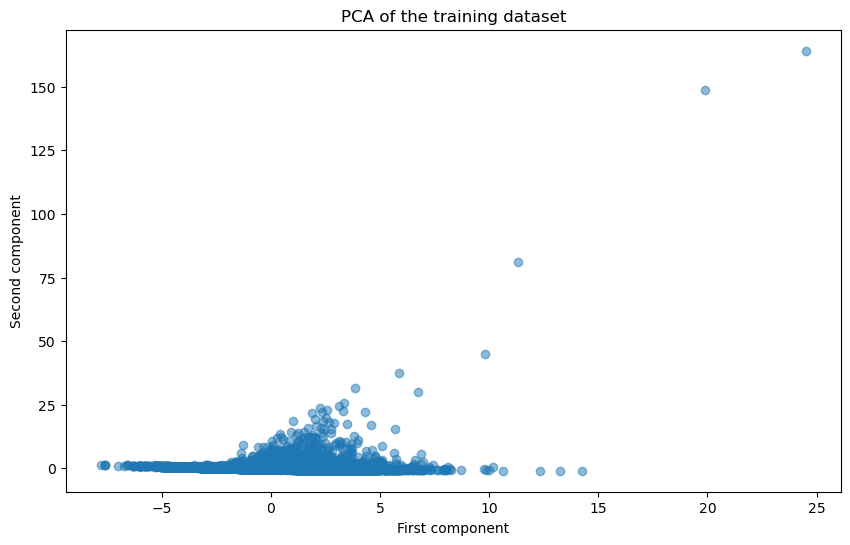

In [10]:
# Visualize the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def plot_pca(dataframe: pd.DataFrame, title: str = "PCA of the dataset"):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.show()


plot_pca(train_df, title="PCA of the training dataset")

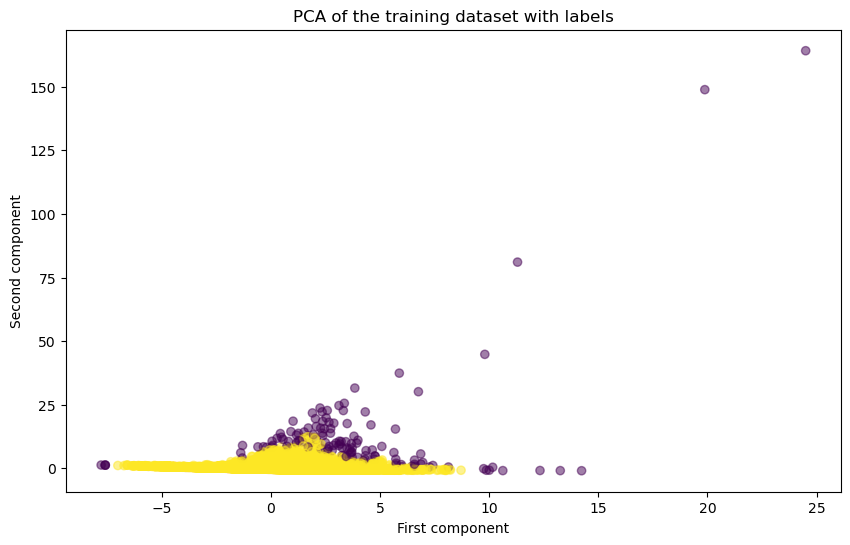

In [11]:
from sklearn.cluster import DBSCAN

def draw_pca(dataframe: pd.DataFrame, labels: pd.DataFrame, title: str):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, alpha=0.5)
    plt.title(title)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.show()
    
def get_labels_dbscan(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    0: anomaly
    1: normal
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)

    clf = DBSCAN(eps=0.5, min_samples=5)
    labels = clf.fit_predict(pca_result)
    labels = (labels != -1).astype(int)
    return labels


train_labels_dbscan = get_labels_dbscan(train_df)

draw_pca(train_df, train_labels_dbscan, title="PCA of the training dataset with labels")

## Convert to tensor

Before converting the data to tensor, print the dataframes to see how it looks like.

In [128]:
train_df

,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type_1,Vehicle_risk_type_2,Vehicle_risk_type_3,Area_0,Area_1
0,-0.465637,0.359865,1.354764,-0.108721,False,True,False,True,False
1,-0.465637,0.457511,1.354764,-0.108721,False,True,False,True,False
3,-0.465637,0.471974,1.354764,-0.108721,False,True,False,True,False
4,-0.387496,-0.592220,0.162470,-0.108721,False,True,False,True,False
5,-0.387496,-0.537010,0.162470,-0.108721,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...
97048,-0.543779,-0.494794,-0.859496,-0.108721,False,True,False,True,False
97049,-0.231212,0.644507,1.354764,-0.108721,False,True,False,True,False
97050,0.003212,1.767362,-1.029824,-0.108721,False,True,False,True,False
97051,2.191177,0.062228,-0.178185,-0.108721,True,False,False,True,False


In [129]:
test_df

,Age,Annual_premium,Vehicle_year,Claim_amount,fraud_reported,Vehicle_risk_type_1,Vehicle_risk_type_2,Vehicle_risk_type_3,Area_0.0,Area_1.0
0,0.990836,0.616705,-0.183440,0.714257,0,False,True,False,False,True
1,0.334073,-0.242521,0.315491,-1.807312,0,False,True,False,False,True
2,-1.088913,0.642233,0.315491,-0.686362,1,False,False,True,False,True
3,0.224613,0.652886,1.479664,0.403135,0,False,True,False,False,True
4,0.552994,1.341980,0.648112,-1.753121,1,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
1010,-0.103769,0.222884,0.149180,1.305049,1,False,True,False,True,False
1011,0.224613,0.739141,1.645974,2.111466,1,False,True,False,True,False
1012,-0.541611,0.520739,-1.513924,0.558507,1,False,True,False,True,False
1013,2.523284,0.411866,-1.181303,-0.219110,1,False,True,False,False,True


In [130]:
data_train = train_df.astype(np.float32).values

data_test = test_df.drop(columns=[label_column]).astype(np.float32).values
data_test_labels = test_df[label_column].values

data_train = torch.tensor(data_train)
data_test = torch.tensor(data_test)
data_test_labels = torch.tensor(data_test_labels).reshape(
    -1, 1
)  # reshape to 2D tensor, because the loss function requires 2D tensor

print(f"train shape: {data_train.shape}")
print(f"test shape: {data_test.shape}")
print(f"test labels shape: {data_test_labels.shape}")

train shape: torch.Size([93383, 9])
test shape: torch.Size([1000, 9])
test labels shape: torch.Size([1000, 1])


Choose GPU as the device to accelerate the training process.

In [131]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Model

### 1. Generator

Define the Generator model, which is a simple fully connected neural network. I have tried to use a complex model, but it seems not to work well. So I use a simple model. 

In [132]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, output_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

### 2. Discriminator

Define the Discriminator model, which is also a simple fully connected neural network. 

I also have tried to use a complex model, but it seems not to work well. I think the reason is that the data is not complex enough. 

In [133]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Train

Here I set the batch_size to 2048 to speed up the training process.

In [134]:
batch_size = 2048
dataloader_train = DataLoader(
    TensorDataset(
        data_train, torch.ones(data_train.shape[0], 1)
    ),
    batch_size=batch_size,
    shuffle=True,
)

dataloader_test = DataLoader(
    TensorDataset(data_test, data_test_labels), batch_size=batch_size, shuffle=True
)

Define a train function to train the model. 

During every batch in a epoch, I use the following steps to train the model:
1. Train the Discriminator
2. Train the Generator

Discriminator is trained to distinguish between normal(from train.csv) and fraud data(from Generator), while Generator is trained to generate fraud data that can fool the Discriminator.

In [135]:
def train_epoch(
    generator,
    discriminator,
    latent_dim,
    optimizer_G,
    optimizer_D,
    dataloader,
    device,
    loss_function,
    epoch_num,
):
    Loss_epoch_D = 0
    Loss_epoch_G = 0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)

        label = torch.ones(data.shape[0], 1).to(device)
        batch_size = data.shape[0]

        # Train Discriminator
        discriminator.train()
        generator.eval()
        optimizer_D.zero_grad()

        real_output = discriminator(data)
        real_loss = loss_function(real_output, label.float())

        latent = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(latent)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_data.detach())
        fake_loss = loss_function(fake_output, fake_labels)

        # Total loss
        discriminator_loss = real_loss + fake_loss
        Loss_epoch_D += discriminator_loss.item()

        discriminator_loss.backward()
        optimizer_D.step()

        #Train Generator
        discriminator.eval()
        generator.train()
        optimizer_G.zero_grad()
        # Train Generator
        latent = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(latent)
        fake_output = discriminator(fake_data)

        real_labels = torch.ones(batch_size, 1).to(device)
        generator_loss = loss_function(fake_output, real_labels)

        Loss_epoch_G += generator_loss.item()

        generator_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch_num} - Discriminator Loss: {Loss_epoch_D:.4f}")
    print(f"Epoch {epoch_num} - Generator Loss: {Loss_epoch_G:.4f}")

I want calculate the recall of anomaly and normal data, so I implement a function.

In [136]:
def class_recall(output: np.ndarray, label: np.ndarray, class_id=0):
    output = output[label == class_id]
    label = label[label == class_id]
    return (output == label).sum() / len(output)

Now train the model. 

In [137]:
import datetime

# Training parameters
epochs = 50
real_label = 1
fake_label = 0


# Initialize Generator and Discriminator
latent_dim = 20
feature_dim = data_train.shape[1]
generator = Generator(latent_dim, feature_dim).to(device)
discriminator = Discriminator(feature_dim).to(device)

# Define loss and optimizers
loss_function = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0004)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

now = datetime.datetime.now()

time = now.strftime("%Y-%m-%d %H_%M")


for epoch in range(epochs):
    train_epoch(
        generator,
        discriminator,
        latent_dim,
        optimizer_G,
        optimizer_D,
        dataloader_train,
        device,
        loss_function,
        epoch,
    )

print("GAN training completed!")

Epoch 0 - Discriminator Loss: 64.6572
Epoch 0 - Generator Loss: 30.0985
Epoch 1 - Discriminator Loss: 63.7927
Epoch 1 - Generator Loss: 29.1815
Epoch 2 - Discriminator Loss: 63.7816
Epoch 2 - Generator Loss: 29.0181
Epoch 3 - Discriminator Loss: 63.7761
Epoch 3 - Generator Loss: 29.4203
Epoch 4 - Discriminator Loss: 63.7749
Epoch 4 - Generator Loss: 29.6185
Epoch 5 - Discriminator Loss: 63.7823
Epoch 5 - Generator Loss: 29.2231
Epoch 6 - Discriminator Loss: 63.7770
Epoch 6 - Generator Loss: 29.2450
Epoch 7 - Discriminator Loss: 63.7821
Epoch 7 - Generator Loss: 28.0615
Epoch 8 - Discriminator Loss: 63.7880
Epoch 8 - Generator Loss: 28.0786
Epoch 9 - Discriminator Loss: 63.7784
Epoch 9 - Generator Loss: 28.4088
Epoch 10 - Discriminator Loss: 63.7835
Epoch 10 - Generator Loss: 28.7723
Epoch 11 - Discriminator Loss: 63.7754
Epoch 11 - Generator Loss: 28.2610
Epoch 12 - Discriminator Loss: 63.7795
Epoch 12 - Generator Loss: 28.6295
Epoch 13 - Discriminator Loss: 63.7843
Epoch 13 - Generato

## Test

Here use the test.csv to test the model.

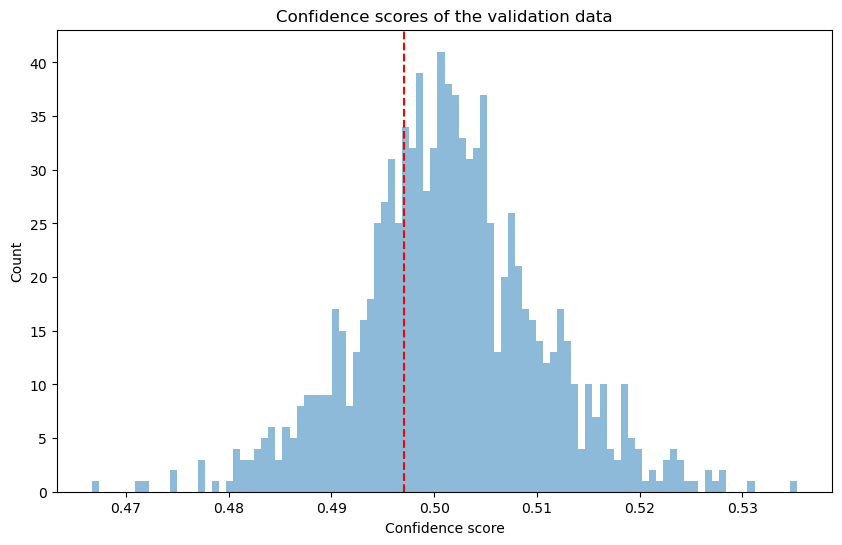

Anomaly threshold: 0.4970608025789261


In [138]:
def visualize_confidence_scores(scores, threshold, title):
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=100, alpha=0.5)
    plt.title(title)
    plt.xlabel("Confidence score")
    plt.ylabel("Count")
    plt.axvline(x=threshold, color="red", linestyle="--", label="Anomaly threshold")
    plt.show()

confidence_scores = discriminator(data_test.to(device)).detach().cpu()
confidence_scores = confidence_scores.numpy()

anomaly_threshold = np.percentile(
    confidence_scores, 30
)

visualize_confidence_scores(
    confidence_scores, anomaly_threshold, "Confidence scores of the validation data"
)
print(f"Anomaly threshold: {anomaly_threshold}")

Anomalies detected: 300


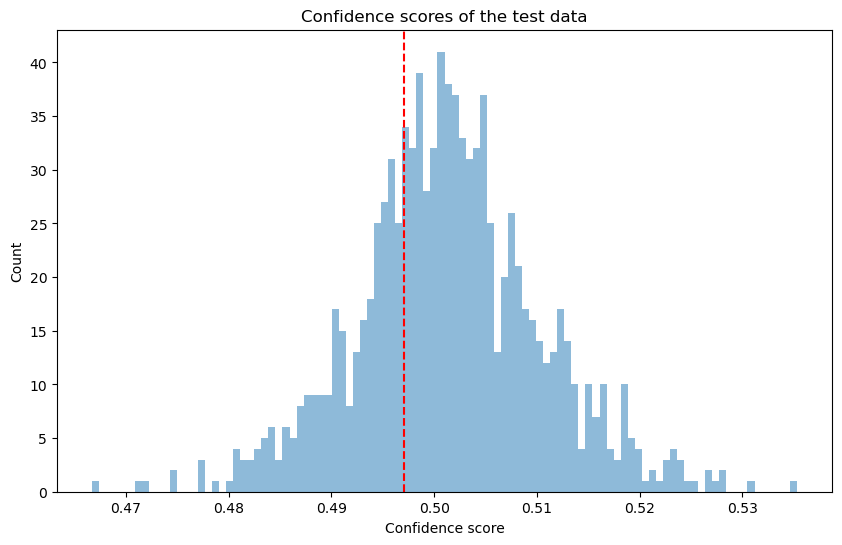

In [139]:
# Pass the test data through the discriminator
discriminator.eval()
confidence_score = discriminator(data_test.to(device)).detach().cpu()

anomalies = torch.sum(confidence_score < anomaly_threshold).item()

print(f"Anomalies detected: {anomalies}")

confidence_score = confidence_score.detach().cpu().numpy()
visualize_confidence_scores(
    confidence_score, anomaly_threshold, "Confidence scores of the test data"
)

Here calculate the metrics of the model, including the recall of anomaly and normal data and f1 score.

In [148]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import prettytable as pt
import numpy as np

def class_recall(output, label, class_id):
    output = np.array(output)
    label = np.array(label)
    mask = (label == class_id)
    filtered_output = output[mask]
    filtered_label = label[mask]
    
    if len(filtered_output) == 0:
        return 0.0
    return np.sum(filtered_output == filtered_label) / len(filtered_output)

classify_result = (confidence_score > anomaly_threshold).astype(int)
confusion_matrix_res = confusion_matrix(data_test_labels, classify_result)

tb = pt.PrettyTable()
tb.field_names = ["", "Predict Anomaly", "Predict Normal"]
tb.add_row(["Actual Anomaly", confusion_matrix_res[0][0], confusion_matrix_res[0][1]])
tb.add_row(["Actual Normal", confusion_matrix_res[1][0], confusion_matrix_res[1][1]])
print(tb)

# F1 Score
f1 = f1_score(data_test_labels, classify_result)
print(f"F1 score: {f1:.4f}")

# Accuracy
acc = accuracy_score(data_test_labels, classify_result)
print(f"Accuracy: {acc:.4f}")

# Anomaly Recall
anomaly_recall = class_recall(classify_result, data_test_labels, class_id=0)
print(f"Anomaly Recall: {anomaly_recall:.4f}")

# Normal Recall
normal_recall = class_recall(classify_result, data_test_labels, class_id=1)
print(f"Normal Recall: {normal_recall:.4f}")

+----------------+-----------------+----------------+
|                | Predict Anomaly | Predict Normal |
+----------------+-----------------+----------------+
| Actual Anomaly |        82       |      165       |
| Actual Normal  |       218       |      535       |
+----------------+-----------------+----------------+
F1 score: 0.7364
Accuracy: 0.6170
Anomaly Recall: 0.3320
Normal Recall: 0.7105
